In [19]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

In [20]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),       # Randomly rotate the images by up to 10 degrees
    transforms.Resize((32, 32)),
    transforms.ToTensor(),         
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])


In [21]:
# Specify the paths to your train and test datasets
train_dataset_path = 'SportDataset/train'
test_dataset_path = 'SportDataset/test'

# Load the datasets using ImageFolder
trainset = ImageFolder(root=train_dataset_path, transform=transform)
testset = ImageFolder(root=test_dataset_path, transform=transform)

# Print out the classes found in the datasets
print(trainset.classes)
print(testset.classes)

# Print out the size of the datasets
print(len(trainset), len(testset))

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

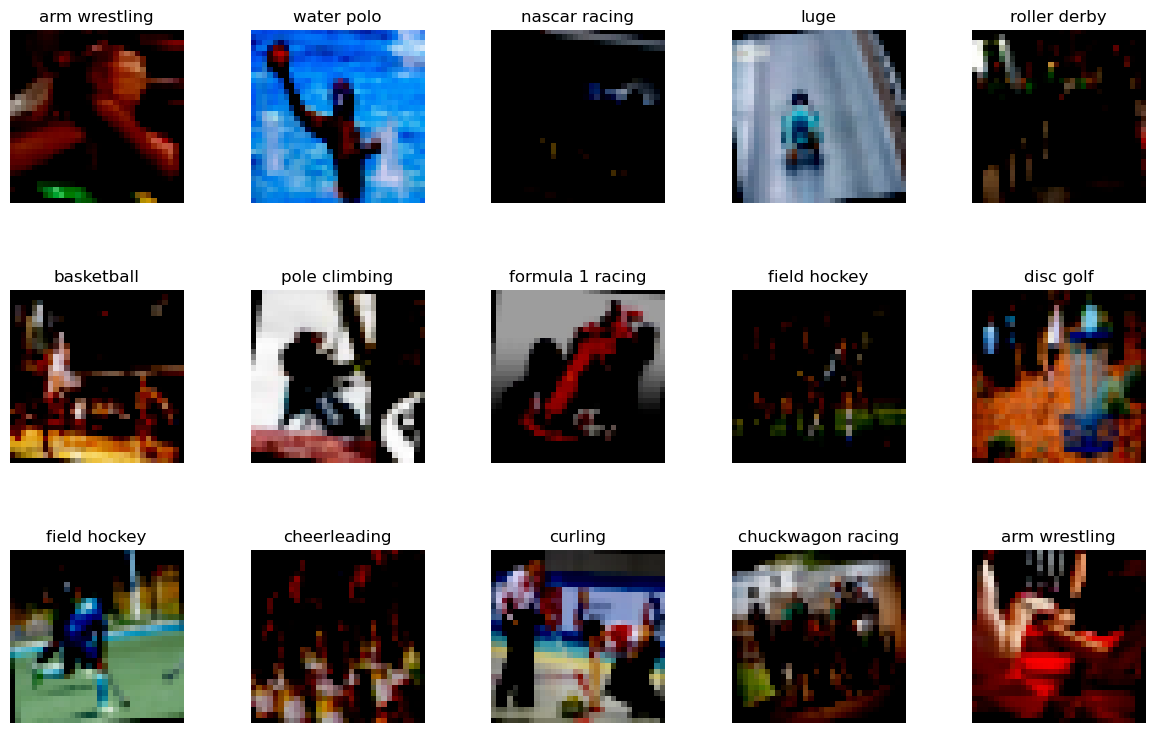

In [22]:
r, c = 3, 5
plt.figure(figsize=(c*3, r*3))

for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        # Transpose image data to shape (224, 224, 3)
        img_transposed = np.transpose(img.numpy(), (1, 2, 0))
        plt.imshow(img_transposed)
        plt.axis('off')
        plt.title(trainset.classes[label])  # Use label to get the corresponding class name

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [23]:
train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:10000], train_images[10000:], train_images[:2000]
y_train, y_val, y_subset = train_labels[:10000], train_labels[10000:], train_labels[:2000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((9000, 3, 32, 32), (4492, 3, 32, 32), (500, 3, 32, 32), (3000, 3, 32, 32))

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=500, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(9000, 4492)

In [26]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=100, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    )

def fit(model, dataloader, epochs=300, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [27]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Epoch 10/300 loss 4.21879 acc 0.01762 val_loss 8.21245 val_acc 0.00000
Epoch 20/300 loss 4.20825 acc 0.01596 val_loss 8.62851 val_acc 0.00000
Epoch 30/300 loss 4.18904 acc 0.02416 val_loss 8.82739 val_acc 0.00000
Epoch 40/300 loss 4.00046 acc 0.03679 val_loss 9.11248 val_acc 0.00000
Epoch 50/300 loss 3.95095 acc 0.04200 val_loss 9.03064 val_acc 0.00000
Epoch 60/300 loss 3.91281 acc 0.04566 val_loss 9.37588 val_acc 0.00000
Epoch 70/300 loss 3.88522 acc 0.04987 val_loss 9.49552 val_acc 0.00000
Epoch 80/300 loss 3.86226 acc 0.04665 val_loss 9.41417 val_acc 0.00000
Epoch 90/300 loss 3.84032 acc 0.05264 val_loss 9.17980 val_acc 0.00000
Epoch 100/300 loss 3.81420 acc 0.05496 val_loss 9.62025 val_acc 0.00000
Epoch 110/300 loss 3.79422 acc 0.05685 val_loss 9.36990 val_acc 0.00000
Epoch 120/300 loss 3.78684 acc 0.06006 val_loss 9.64882 val_acc 0.00000
Epoch 130/300 loss 3.76101 acc 0.06006 val_loss 9.47793 val_acc 0.00000
Epoch 140/300 loss 3.73832 acc 0.06139 val_loss 9.74351 val_acc 0.00000
E

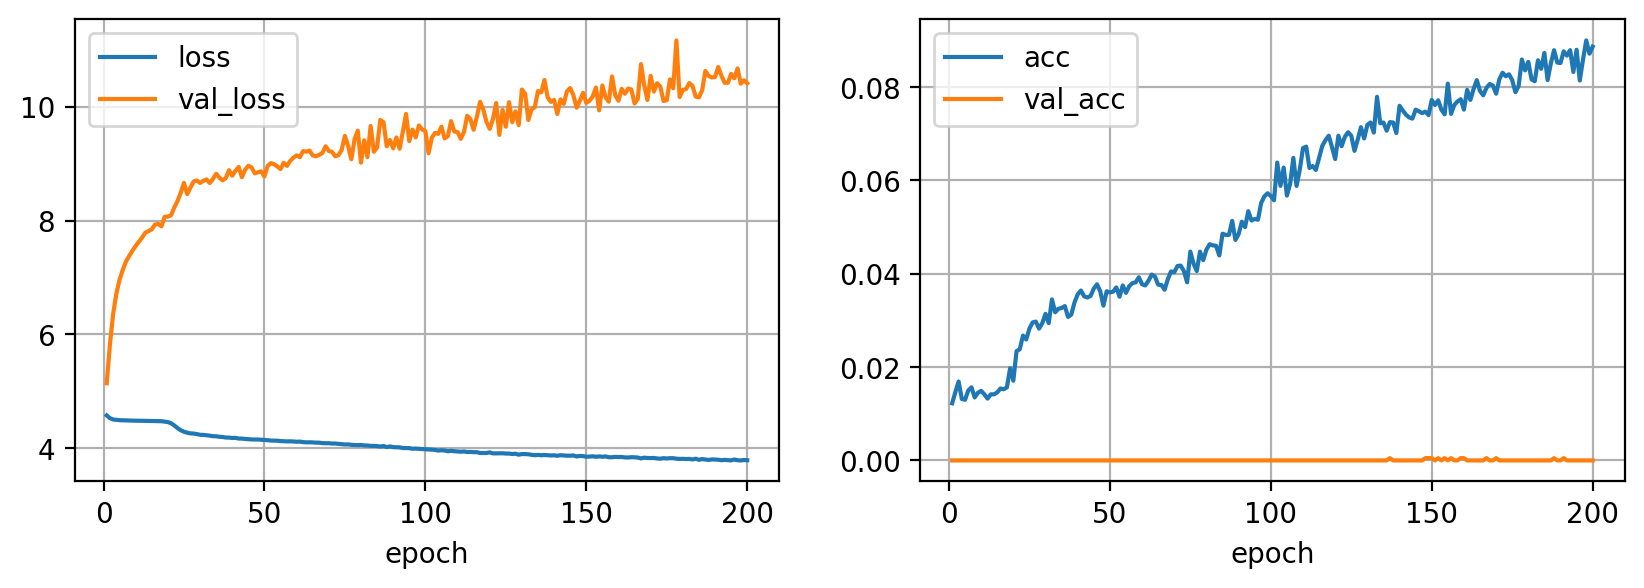

In [18]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()